<!-- PS-S4.E11 | Starter EDA & Modeling -->

<div style="font-family: 'Poppins'; font-weight: bold; letter-spacing: 0px; color: #FFFFFF; font-size: 300%; text-align: left; padding: 15px; background: #0A0F29; border: 8px solid #00FFFF; border-radius: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5);">
   PS-S4.E11 | Starter EDA & Modeling <br>
</div>

<div style="text-align: center;">
  <img src="https://i.imgur.com/EhXAhl1.jpg" alt="Centered Image" style="max-width: 60%; height: auto;">
</div>

Photo de <a href="https://unsplash.com/fr/@dmey503?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Dan Meyers</a> sur <a href="https://unsplash.com/fr/photos/nabandonnez-pas-vous-netes-pas-seul-vous-comptez-sur-la-signalisation-sur-la-cloture-metallique-hluOJZjLVXc?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Introduction</div>

## <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Challenge Overview 📚</div>

- **Objective:** Participants analyze a synthetic dataset based on a mental health survey to identify factors linked to depression, predicting whether individuals are likely to experience depression.
- **Evaluation:** Submissions are scored by accuracy, with predictions required for each row in the test set as either 0 (no depression) or 1 (depression).

## <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Dataset Description 📊 </div>

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Mental Health Survey dataset. Feature distributions are close to, but not exactly the same, as the original dataset. 

Files:
- train.csv - The training dataset; Depression is the binary target variable indicating whether an individual is experiencing depression (1) or not (0).
- test.csv - The test dataset; your objective is to predict the probability of the target Depression for each row.
sample_submission.csv - A sample submission file that provides the expected format for your submissions.

## <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Evaluation Metric</div>

Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

In [1]:
!pip install sweetviz > /dev/null 2>&1
!pip install optuna-integration[sklearn] > /dev/null 2>&1
!pip install langchain-core > /dev/null 2>&1
!pip install langchain-openai  > /dev/null 2>&1
!pip install catboost > /dev/null 2>&1

In [2]:
# Import libraries

# LLM
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
import json

# General Purpose Libraries
import logging
import numpy as np
import pandas as pd
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

# Scikit-Learn Utilities
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     cross_val_score, RandomizedSearchCV)

# Scikit-Learn Classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, VotingClassifier)

# Import CatBoostClassifier
from catboost import CatBoostClassifier

# Feature engineering
from sklearn.preprocessing import KBinsDiscretizer
from featuretools import dfs, EntitySet

# External Libraries Classifiers
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, log_evaluation

# Metrics and Scoring
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, make_scorer)

# Optuna for Hyperparameter Tuning
import optuna
from optuna.integration import OptunaSearchCV

from IPython.display import Markdown, display
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning, message="underflow encountered*")

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
OPENAI_API_KEY = user_secrets.get_secret("openai_key")

In [4]:
N_TRIALS = 25

In [5]:
# Updated classify_columns function to skip 'id' or 'ID'
def classify_columns(df):
    continuous_cols = []
    categorical_cols = []
    for column in df.columns:
        if column.lower() == 'id':  # Skip id or ID
            continue
        if df[column].dtypes == 'object':
            categorical_cols.append(column)
        else:
            unique_values = df[column].nunique()
            if unique_values < 15:
                categorical_cols.append(column)
            else:
                continuous_cols.append(column)
    return continuous_cols, categorical_cols

# Updated EDA visualizations function to skip 'id' or 'ID' and limit top 20 categories for plots
def eda_visualizations(df, target=None):
    continuous_cols, categorical_cols = classify_columns(df)
    
    # Plotting continuous columns
    for col in continuous_cols:
        if col.lower() == 'id':  # Skip id or ID
            continue
        plt.figure(figsize=(10, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    
    # Plotting categorical columns with top 20 categories only
    for col in categorical_cols:
        if col.lower() == 'id':  # Skip id or ID
            continue
        top_categories = df[col].value_counts().nlargest(20).index  # Select top 20 categories
        filtered_df = df[df[col].isin(top_categories)]  # Filter dataframe
        plt.figure(figsize=(10, 4))
        sns.countplot(data=filtered_df, x=col, hue=target, order=top_categories)
        plt.title(f'Count plot for {col} (Top 20 Categories)')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

# Updated compare_train_test function to skip 'id' or 'ID' and limit top 20 categories for plots
def compare_train_test(train, test):
    continuous_cols, categorical_cols = classify_columns(train)
    
    # Compare continuous columns
    for col in continuous_cols:
        if col.lower() == 'id':  # Skip id or ID
            continue
        plt.figure(figsize=(10, 4))
        sns.kdeplot(train[col], label='Train', shade=True)
        sns.kdeplot(test[col], label='Test', shade=True)
        plt.title(f'Comparison of {col} Distribution in Train vs Test')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    
    # Compare categorical columns with top 20 categories only
    for col in categorical_cols:
        if col.lower() == 'id':  # Skip id or ID
            continue
        if col in test.columns:  # Ensure the column exists in the test dataset
            top_categories = train[col].value_counts().nlargest(20).index  # Select top 20 categories in train
            filtered_train = train[train[col].isin(top_categories)]
            filtered_test = test[test[col].isin(top_categories)]
            train_counts = filtered_train[col].value_counts(normalize=True)
            test_counts = filtered_test[col].value_counts(normalize=True)
            plt.figure(figsize=(10, 4))
            train_counts.plot(kind='bar', alpha=0.5, label='Train', color='blue')
            test_counts.plot(kind='bar', alpha=0.5, label='Test', color='red')
            plt.title(f'Comparison of {col} Proportions in Train vs Test (Top 20 Categories)')
            plt.xlabel(col)
            plt.ylabel('Proportion')
            plt.legend()
            plt.xticks(rotation=45)
            plt.show()

def eda_summary(df):
    summary = {}
    
    # General Info
    summary['general'] = {
        'num_rows': df.shape[0],
        'num_columns': df.shape[1],
        'num_missing_values': df.isnull().sum().sum(),
        'percent_missing_values': df.isnull().mean().mean() * 100
    }
    
    # Column Data Types
    summary['data_types'] = {k: v for k, v in df.dtypes.to_dict().items() if k.lower() != 'id'}
    
    # Missing Value Summary (per column)
    summary['missing_values'] = (
        df.drop(columns=[col for col in df.columns if col.lower() == 'id'])
        .isnull()
        .sum()
        .to_frame(name='missing_count')
        .assign(percent_missing=lambda x: (x['missing_count'] / df.shape[0]) * 100)
        .to_dict(orient='index')
    )
    
    # Numerical Summary (Mean, Median, Std, Min, Max)
    describe_df = df.describe()
    numerical_columns = ['mean', '50%', 'std', 'min', 'max']
    available_columns = [col for col in numerical_columns if col in describe_df.columns]
    summary['numerical_summary'] = (
        describe_df[available_columns]
        .rename(columns={'50%': 'median'})
        .drop(columns=[col for col in describe_df.columns if col.lower() == 'id'], errors='ignore')
        .to_dict(orient='index')
    )
    
    # Unique Counts for Categorical Columns
    summary['categorical_summary'] = (
        df.select_dtypes(include=['object', 'category'])
        .drop(columns=[col for col in df.select_dtypes(include=['object', 'category']).columns if col.lower() == 'id'], errors='ignore')
        .nunique()
        .to_frame(name='unique_counts')
        .to_dict(orient='index')
    )
    
    # Skewness and Kurtosis
    summary['skewness_kurtosis'] = {
        column: {
            'skewness': df[column].skew(),
            'kurtosis': df[column].kurt()
        } for column in df.select_dtypes(include=[np.number]).columns if column.lower() != 'id'
    }
    
    # Correlations
    try:
        summary['correlations'] = df.drop(columns=[col for col in df.columns if col.lower() == 'id']).corr(numeric_only=True).to_dict()
    except ValueError:
        summary['correlations'] = "Unable to calculate correlations due to data type issues."
    
    # Outlier Count based on IQR
    outlier_summary = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        if column.lower() == 'id':  # Skip id or ID
            continue
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
        outlier_summary[column] = {
            'outlier_count': outliers.shape[0],
            'percent_outliers': (outliers.shape[0] / df.shape[0]) * 100
        }
    summary['outlier_summary'] = outlier_summary

    return summary

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Simple EDA 📈</div>

In [6]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')

In [7]:
# Basic Exploration
train_data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [8]:
train_data.shape

(140700, 20)

In [9]:
train_data.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000,140700.000000
mean,70349.500000,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983,0.181713
std,40616.735775,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633,0.385609
min,0.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


In [10]:
test_data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
1,140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
2,140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
3,140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
4,140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No


In [11]:
test_data.shape

(93800, 19)

In [12]:
test_data.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress
count,93800.000000,93800.000000,18767.000000,75022.000000,18766.000000,18767.000000,75026.00000,93800.000000,93800.000000
mean,187599.500000,40.321685,3.158576,3.011797,7.674016,2.939522,2.96092,6.247335,2.978763
std,27077.871962,12.393480,1.386666,1.403563,1.465056,1.374242,1.41071,3.858191,1.414604
min,140700.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.00000,0.000000,1.000000
25%,164149.750000,29.000000,2.000000,2.000000,6.330000,2.000000,2.00000,3.000000,2.000000
50%,187599.500000,42.000000,3.000000,3.000000,7.800000,3.000000,3.00000,6.000000,3.000000
75%,211049.250000,51.000000,4.000000,4.000000,8.940000,4.000000,4.00000,10.000000,4.000000
max,234499.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.00000,12.000000,5.000000


In [13]:
sample_submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,0
4,140704,0


In [14]:
train_data.shape

(140700, 20)

In [15]:
test_data.shape

(93800, 19)

In [16]:
train_data.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000,140700.000000
mean,70349.500000,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983,0.181713
std,40616.735775,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633,0.385609
min,0.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


In [17]:
test_data.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress
count,93800.000000,93800.000000,18767.000000,75022.000000,18766.000000,18767.000000,75026.00000,93800.000000,93800.000000
mean,187599.500000,40.321685,3.158576,3.011797,7.674016,2.939522,2.96092,6.247335,2.978763
std,27077.871962,12.393480,1.386666,1.403563,1.465056,1.374242,1.41071,3.858191,1.414604
min,140700.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.00000,0.000000,1.000000
25%,164149.750000,29.000000,2.000000,2.000000,6.330000,2.000000,2.00000,3.000000,2.000000
50%,187599.500000,42.000000,3.000000,3.000000,7.800000,3.000000,3.00000,6.000000,3.000000
75%,211049.250000,51.000000,4.000000,4.000000,8.940000,4.000000,4.00000,10.000000,4.000000
max,234499.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.00000,12.000000,5.000000


In [18]:
# Automated EDA report with sweetviz

# Comparing the train and test datasets
report = sv.compare([train_data, "Train"], [test_data, "Test"])
report.show_html(filepath='/kaggle/working/Comparative_EDA_Report.html', open_browser=False)

                                             |          | [  0%]   00:00 -> (? left)

Report /kaggle/working/Comparative_EDA_Report.html was generated.


*  EDA in Output/Comparative_EDA_Report.html

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


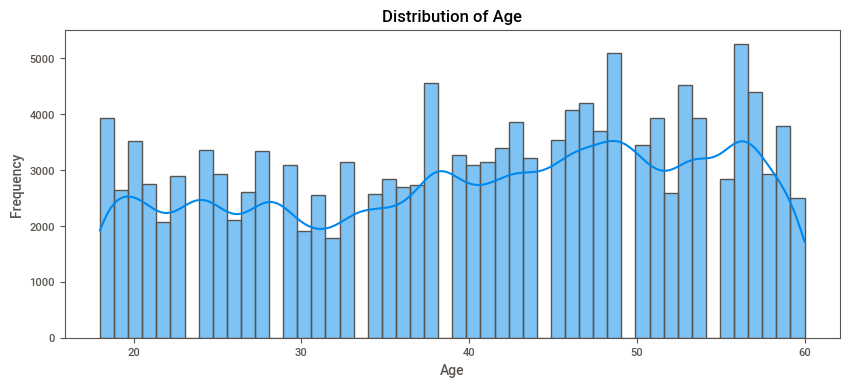

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


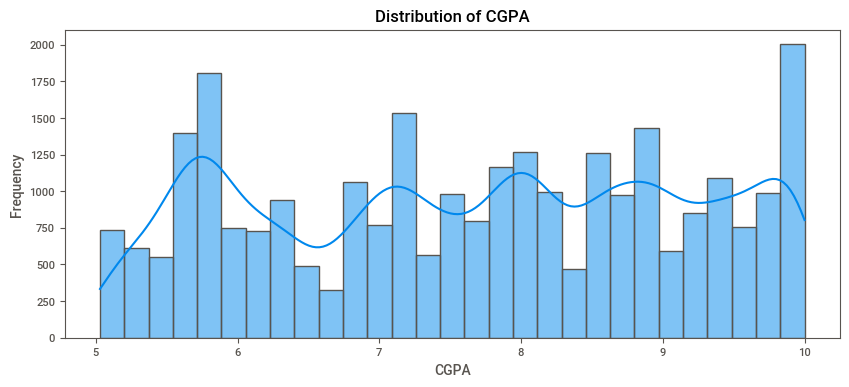

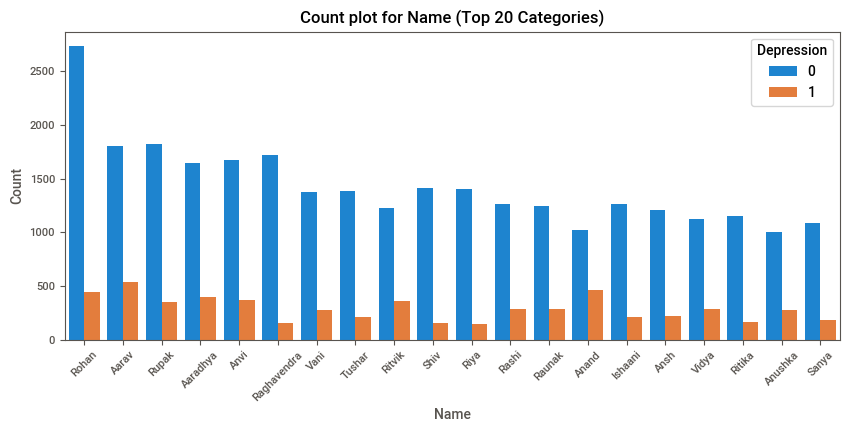

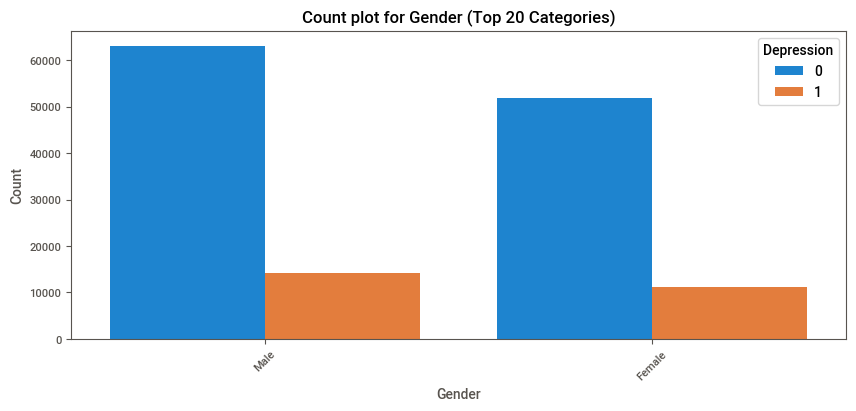

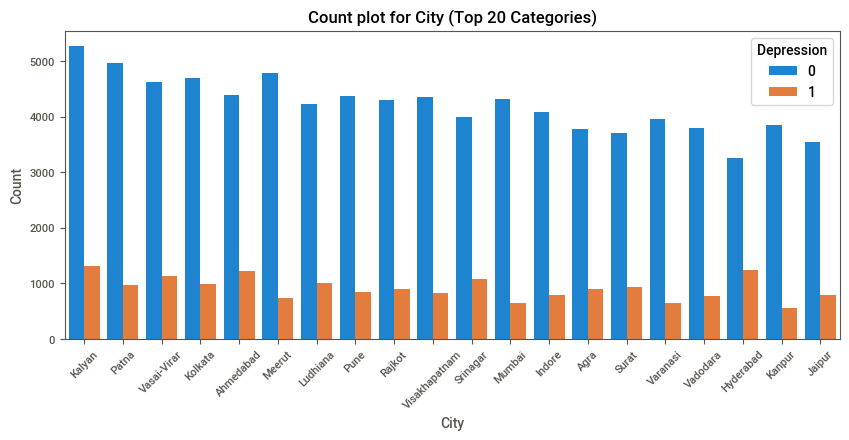

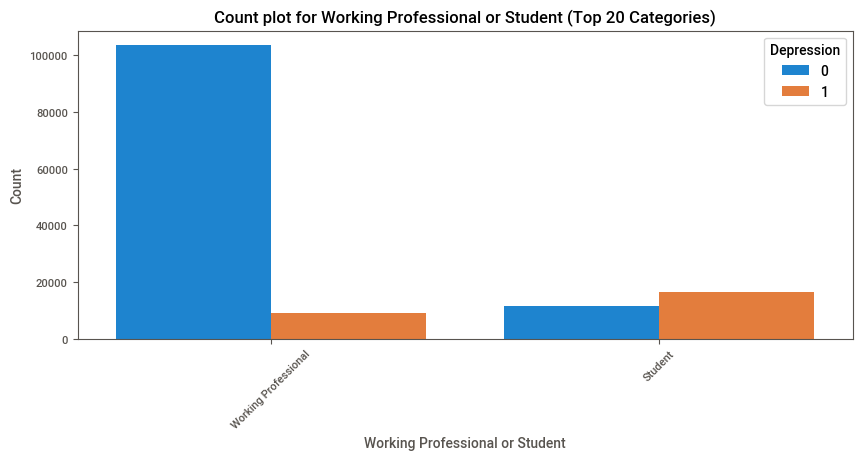

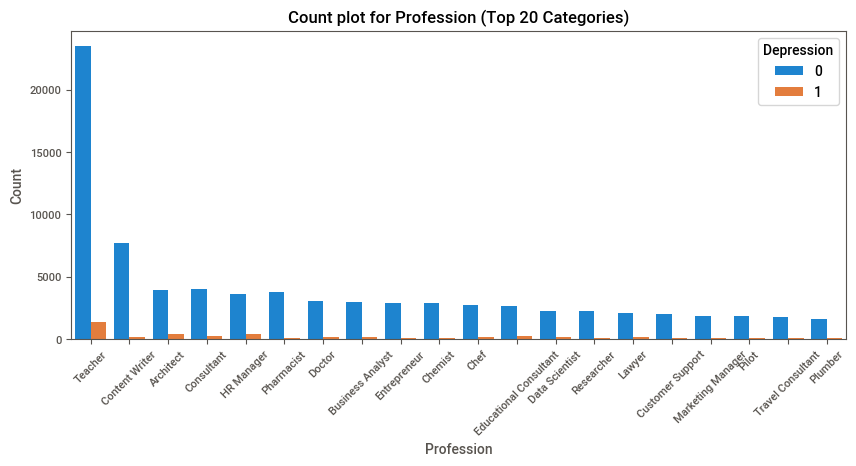

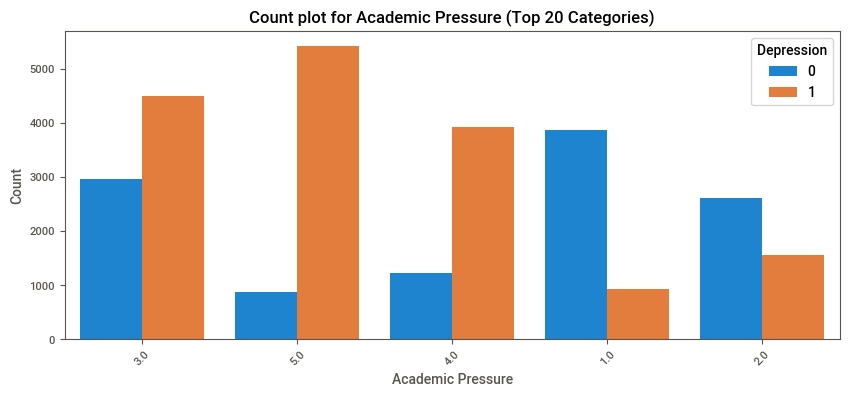

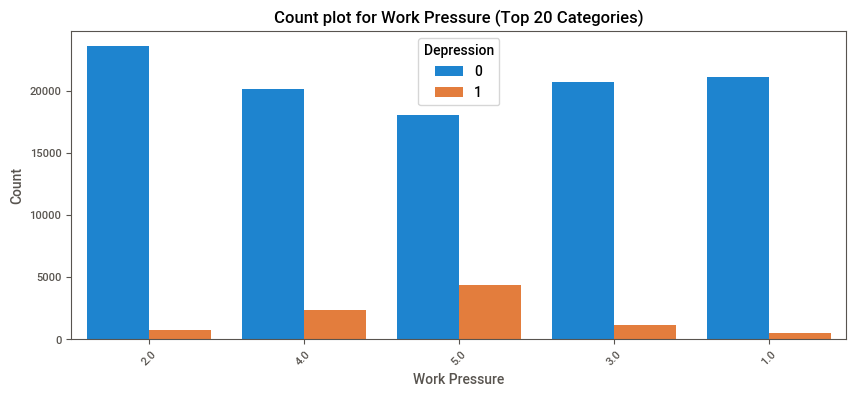

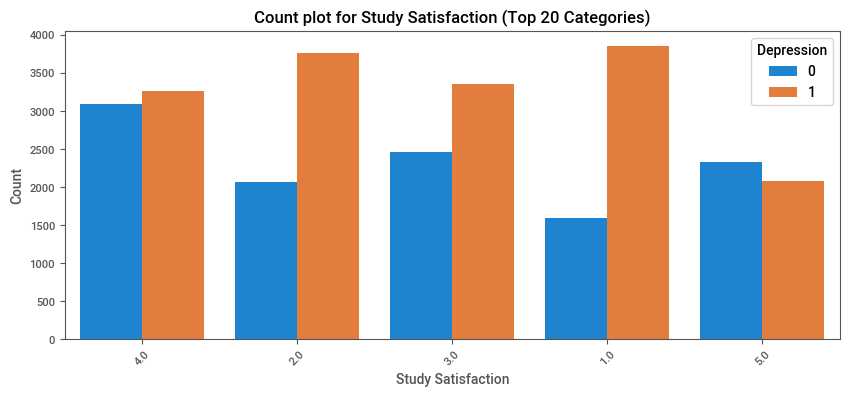

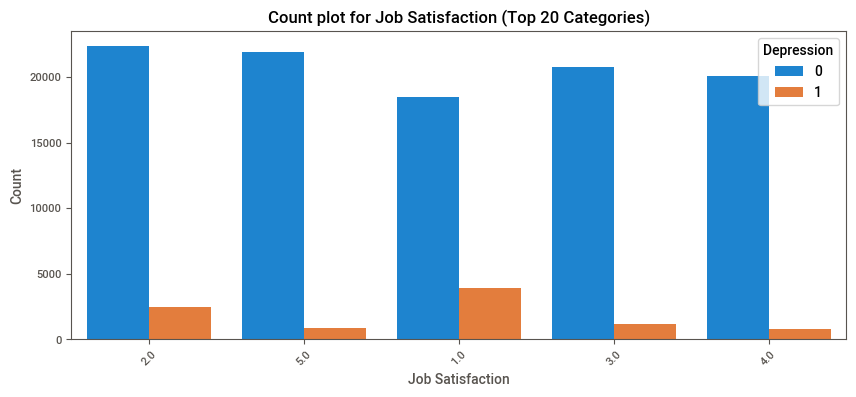

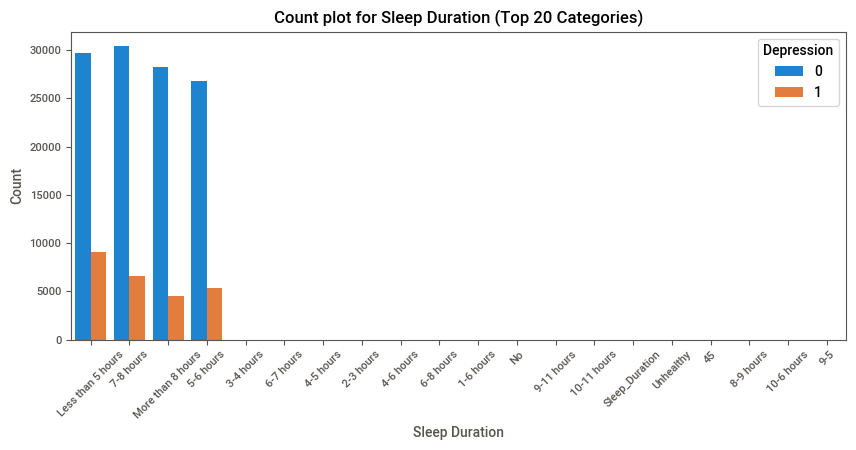

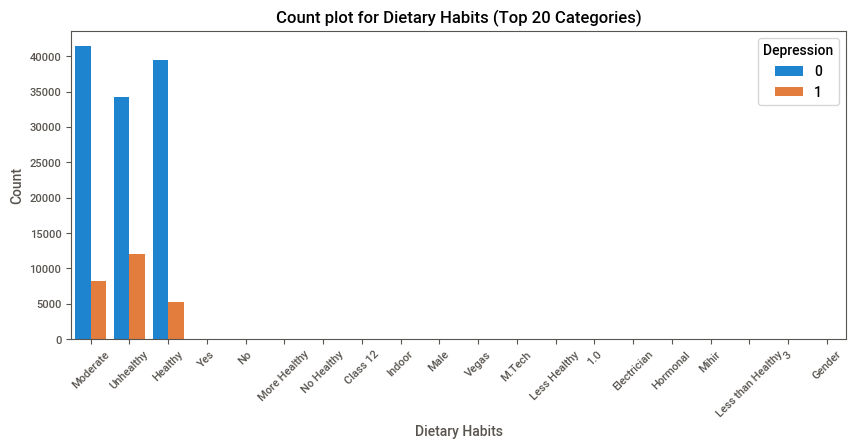

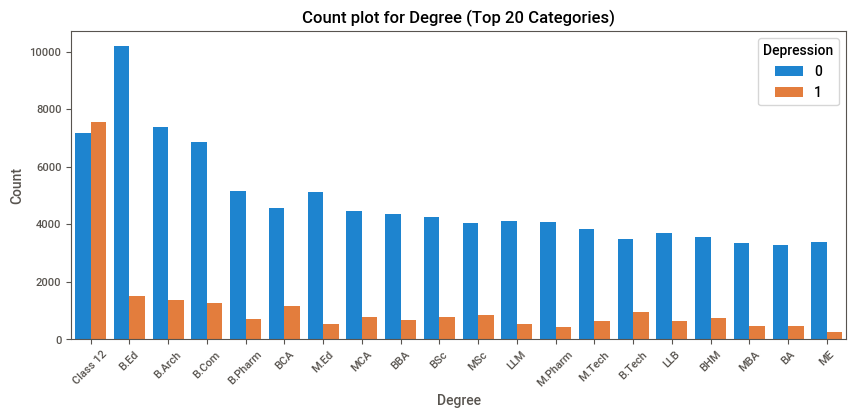

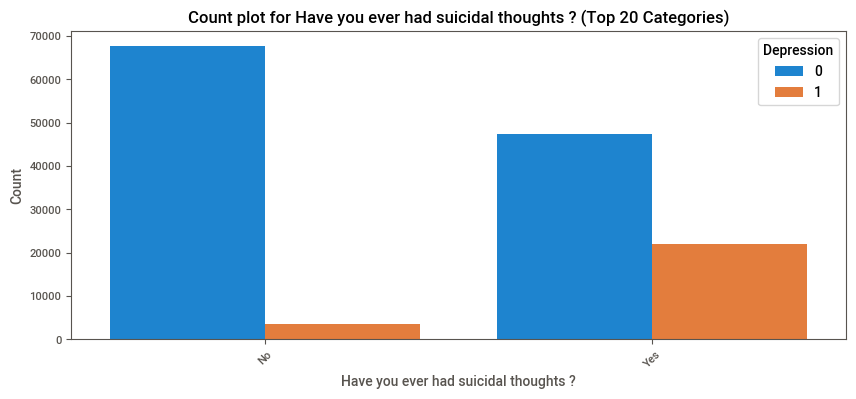

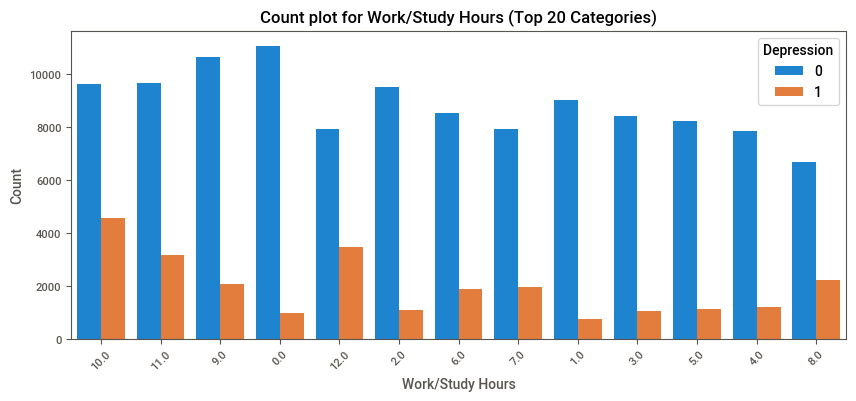

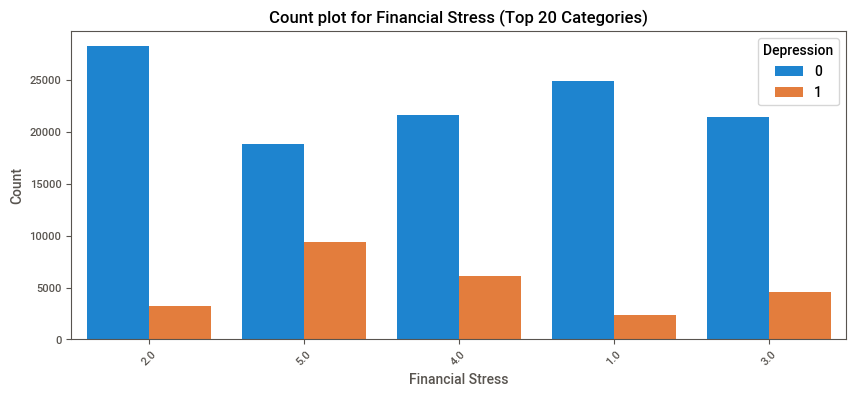

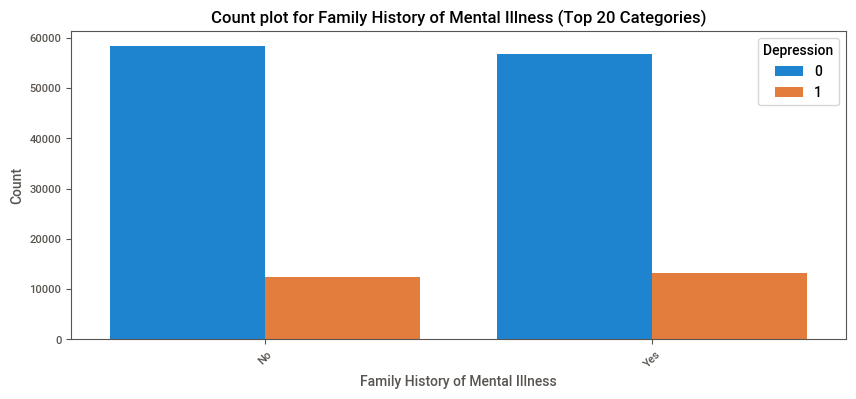

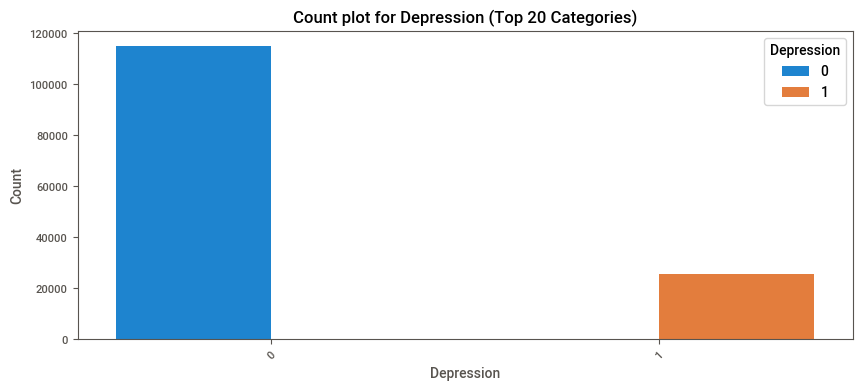

In [19]:
# Automated EDA
eda_visualizations(train_data, target='Depression')

/tmp/ipykernel_17/1777786969.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col], label='Train', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_17/1777786969.py:57: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col], label='Test', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

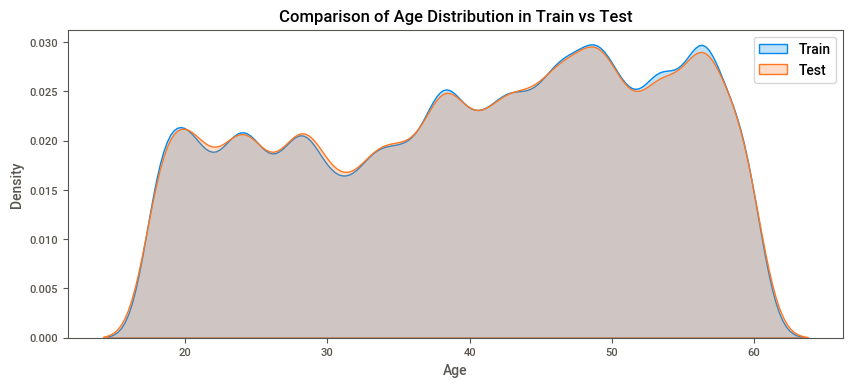

/tmp/ipykernel_17/1777786969.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col], label='Train', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_17/1777786969.py:57: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col], label='Test', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

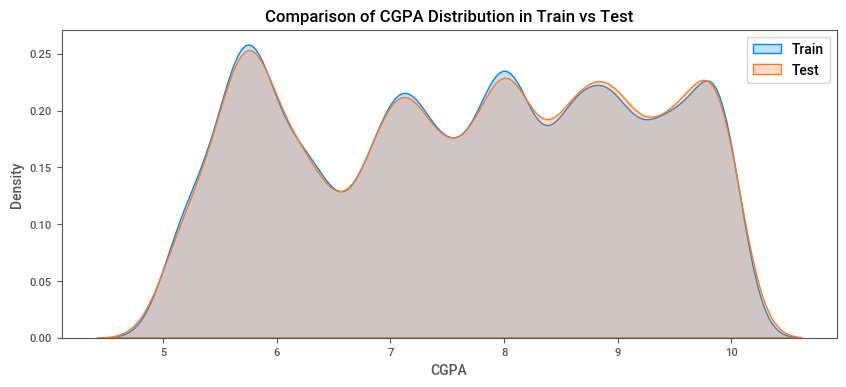

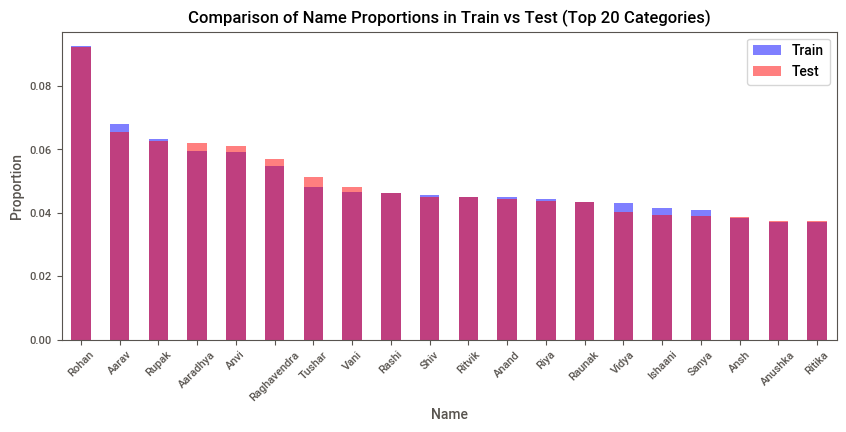

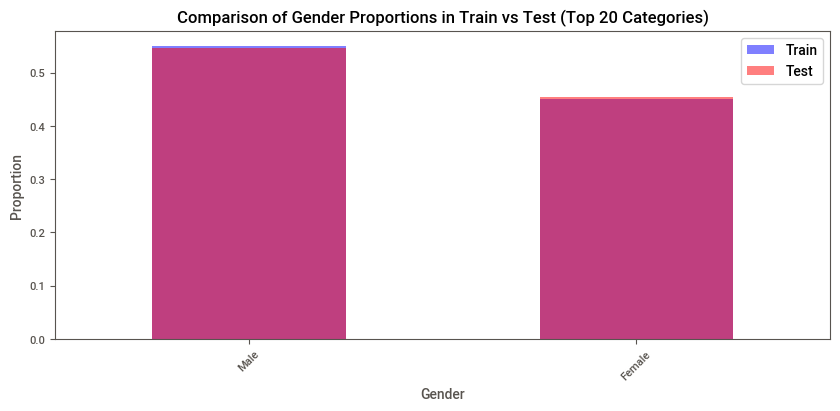

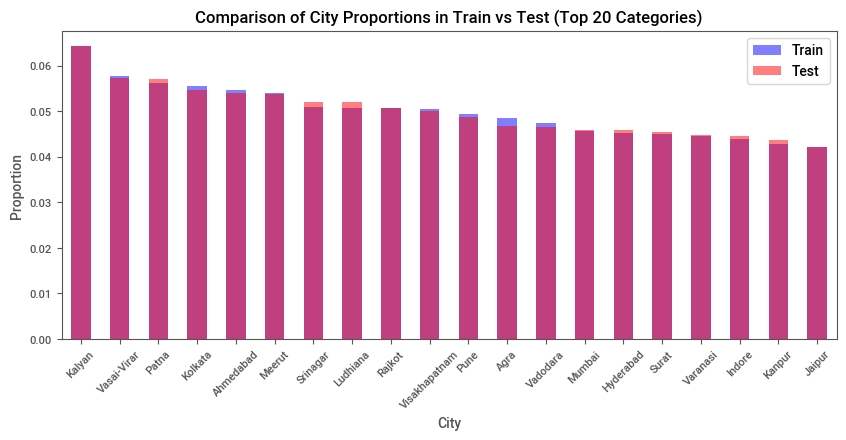

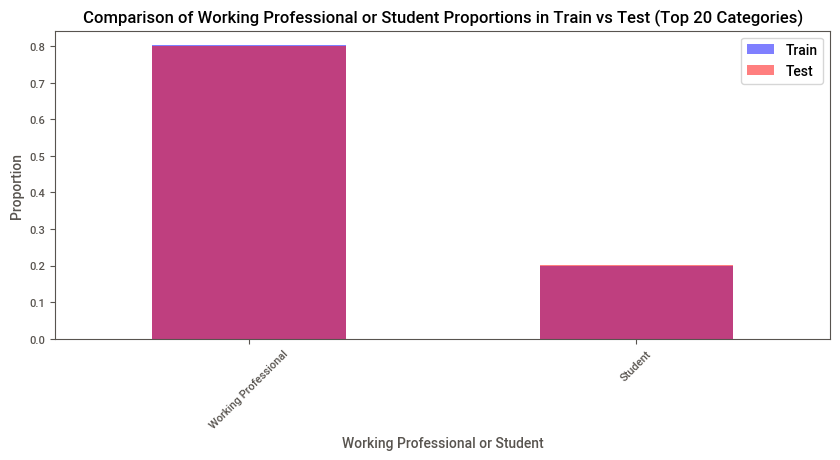

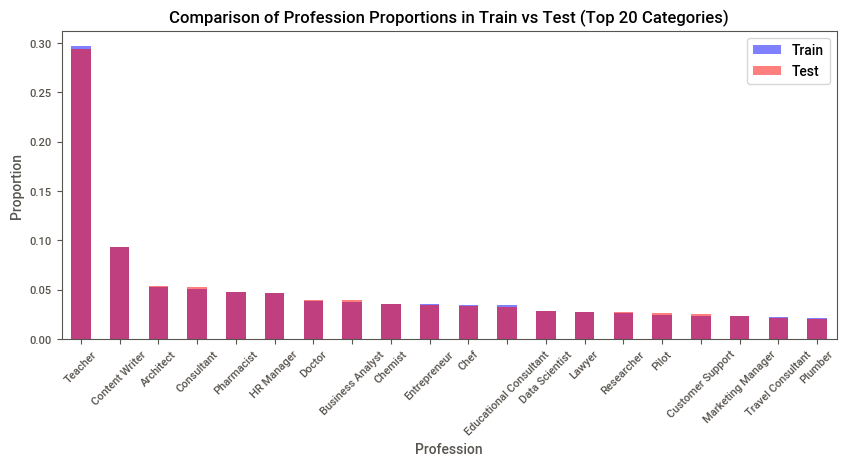

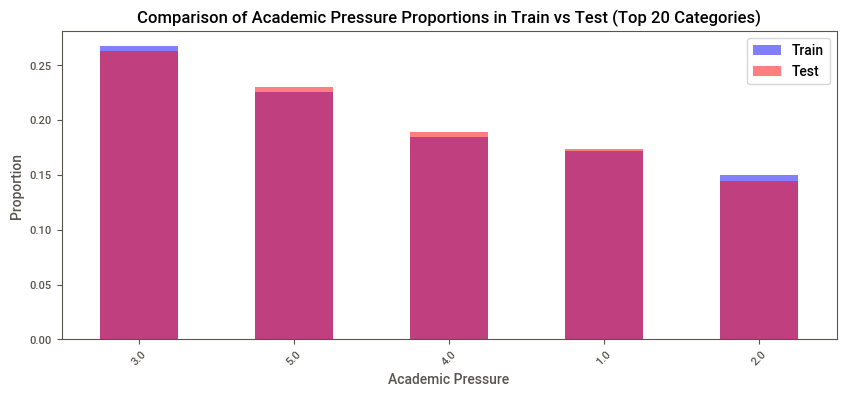

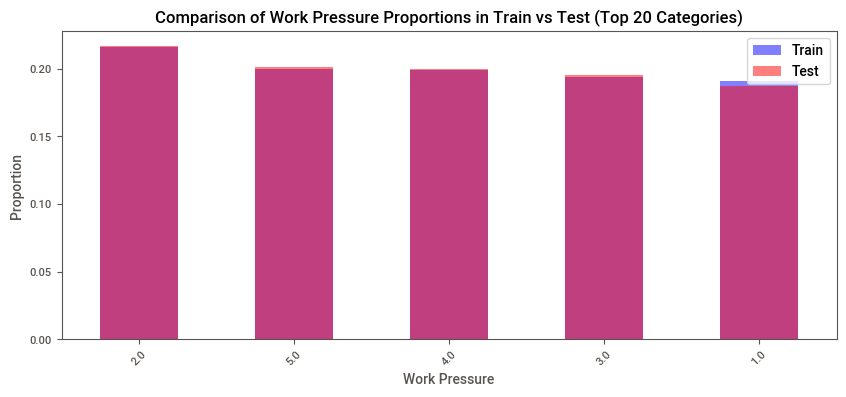

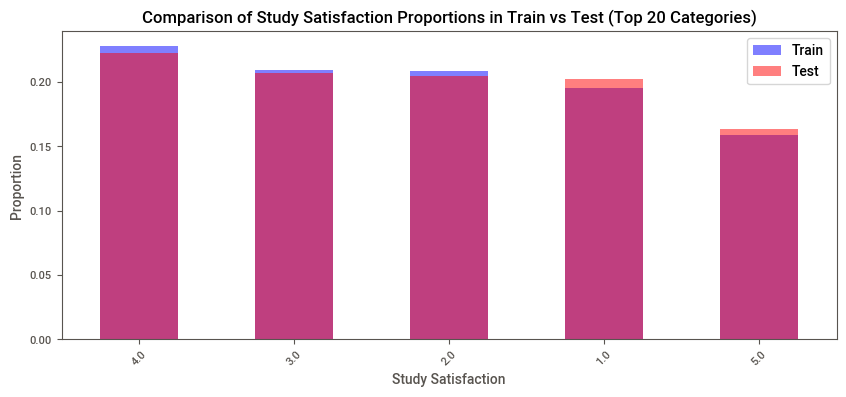

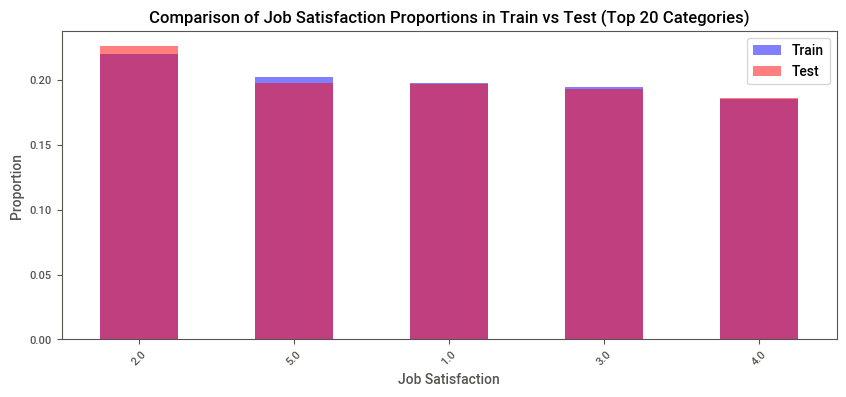

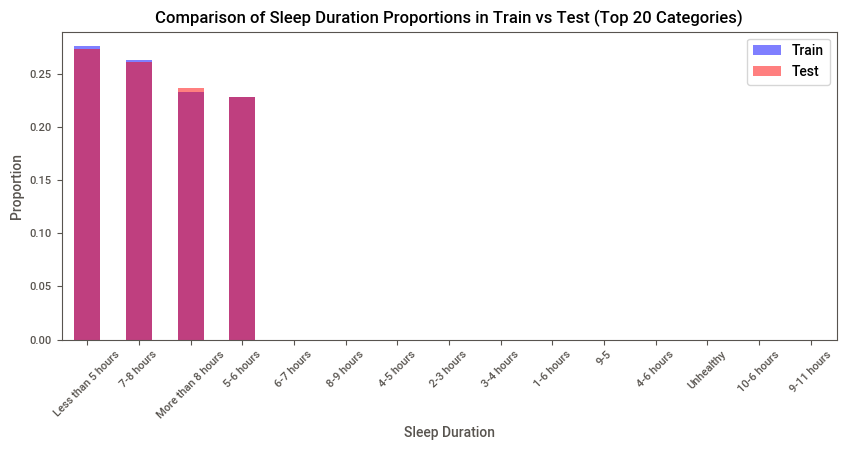

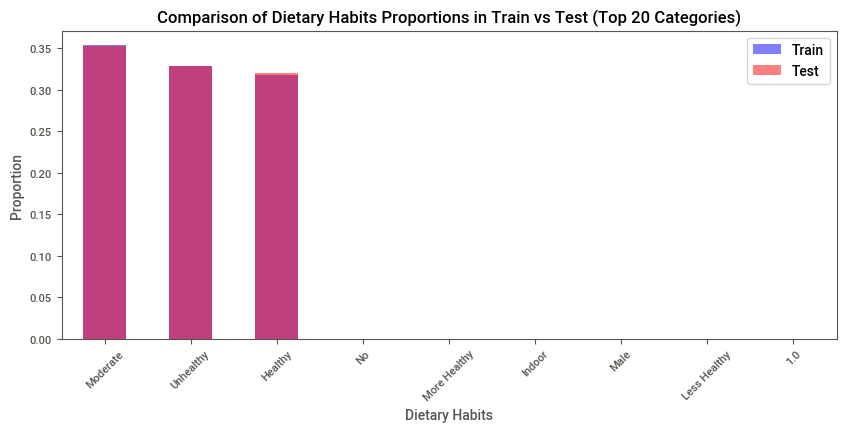

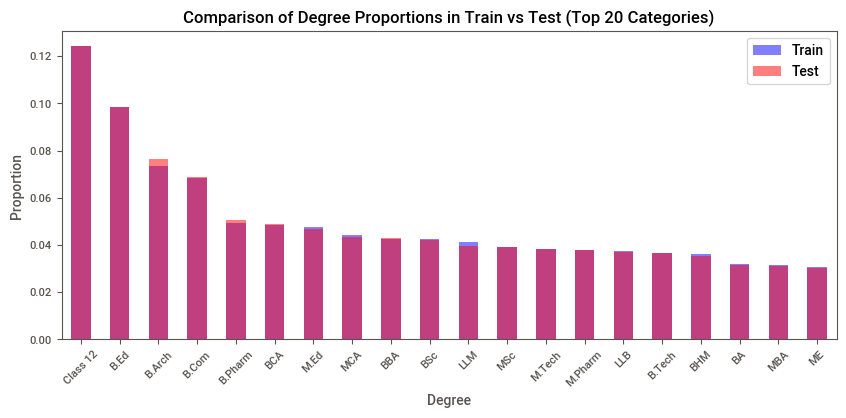

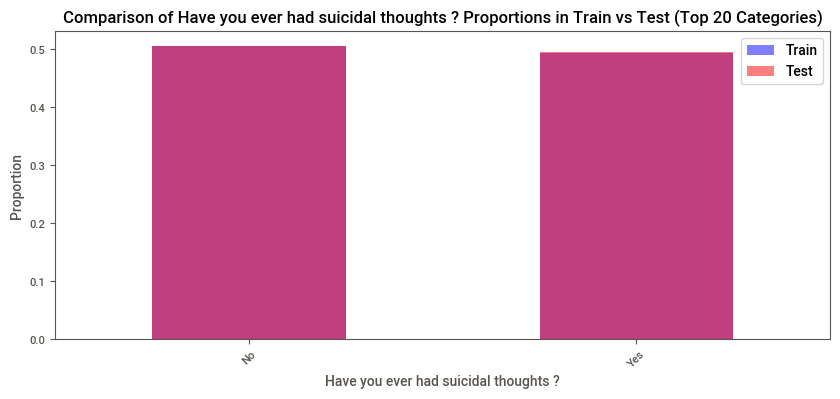

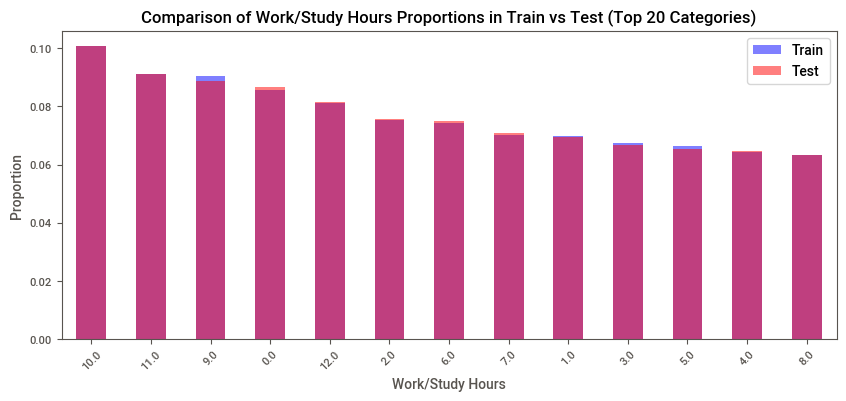

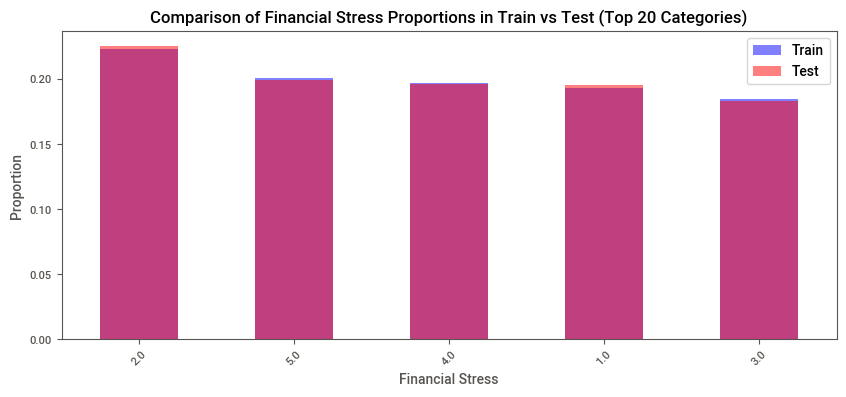

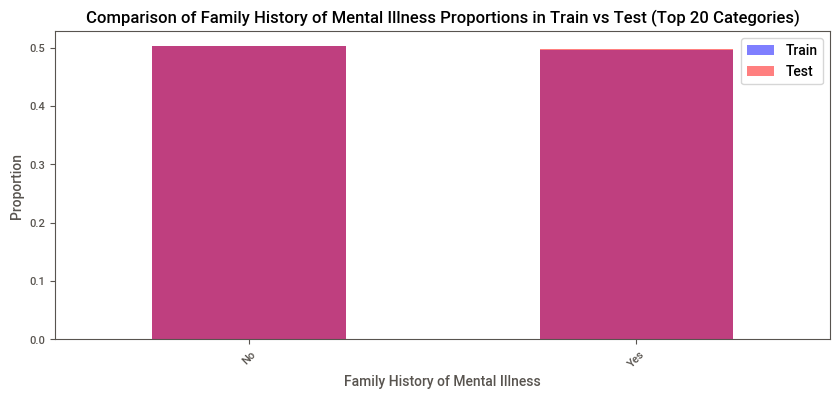

In [20]:
# Comparing train and test datasets
compare_train_test(train_data, test_data)

In [21]:
summary = eda_summary(train_data)

# Convert summary to JSON format
summary_json = json.dumps(summary, indent=4, default=str)

In [22]:
# Define the prompt template for LangChain
template = """Provide an analysis of the following EDA summary:
{context}

Key insights and observations:
"""

prompt = ChatPromptTemplate.from_template(template)

# Define the LLM model using LangChain
model = ChatOpenAI(
    model='gpt-4o-2024-05-13',
    temperature=0,
    api_key=OPENAI_API_KEY
)

# Create a chain to pass the summary to the model
chain = prompt | model | StrOutputParser()

# Invoke the chain to analyze the EDA summary
result = chain.invoke(summary_json)

# Print the result
display(Markdown(result))

The provided Exploratory Data Analysis (EDA) summary offers a comprehensive overview of a dataset with 140,700 rows and 20 columns. Here are the key insights and observations:

### General Overview
- **Number of Rows and Columns**: The dataset contains 140,700 rows and 20 columns.
- **Missing Values**: There are 430,876 missing values, which constitute approximately 15.31% of the entire dataset.

### Data Types
- The dataset includes a mix of data types:
  - **Object (Categorical)**: 10 columns (e.g., Name, Gender, City)
  - **Float64 (Numerical)**: 8 columns (e.g., Age, Academic Pressure, Work Pressure)
  - **Int64 (Numerical)**: 1 column (Depression)

### Missing Values
- **High Missing Values**: 
  - `Academic Pressure`, `CGPA`, and `Study Satisfaction` have around 80% missing values.
  - `Profession` has 26% missing values.
  - `Work Pressure` and `Job Satisfaction` have around 20% missing values.
- **Low Missing Values**: 
  - `Dietary Habits`, `Degree`, and `Financial Stress` have negligible missing values (less than 0.003%).
- **No Missing Values**: 
  - Columns like `Name`, `Gender`, `Age`, `City`, `Working Professional or Student`, `Sleep Duration`, `Have you ever had suicidal thoughts?`, `Work/Study Hours`, `Family History of Mental Illness`, and `Depression` have no missing values.

### Categorical Summary
- **Unique Counts**:
  - `Name` has 422 unique values, indicating potential duplicates or multiple entries for some names.
  - `City` has 98 unique values, suggesting a diverse geographical representation.
  - `Profession` has 64 unique values, indicating a variety of professions.
  - `Degree` has 115 unique values, showing a wide range of educational qualifications.
  - `Sleep Duration` and `Dietary Habits` have 36 and 23 unique values, respectively, which might need further categorization or binning.

### Skewness and Kurtosis
- **Skewness**: Most numerical columns have skewness values close to zero, indicating a relatively symmetric distribution. However, `Depression` has a high positive skewness (1.65), suggesting a right-skewed distribution.
- **Kurtosis**: Most columns have negative kurtosis values, indicating a flatter distribution than a normal distribution. `Depression` has a positive kurtosis (0.725), indicating a distribution with heavier tails.

### Correlations
- **Strong Negative Correlation**:
  - `Age` and `Depression` (-0.565): Older individuals tend to have lower depression scores.
- **Strong Positive Correlation**:
  - `Academic Pressure` and `Depression` (0.475): Higher academic pressure is associated with higher depression scores.
  - `Financial Stress` and `Depression` (0.227): Higher financial stress is associated with higher depression scores.
- **Notable Correlations**:
  - `Job Satisfaction` and `CGPA` (1.0): Perfect correlation, which might indicate a data issue or redundancy.
  - `Job Satisfaction` and `Study Satisfaction` (-1.0): Perfect negative correlation, suggesting an inverse relationship.

### Outlier Summary
- **Depression**: 18.17% of the values are outliers, indicating a significant number of extreme values in the depression scores.
- **Other Columns**: No outliers detected in other numerical columns.

### Key Insights
1. **High Missing Values**: The dataset has a significant amount of missing data, especially in columns related to academic and job satisfaction. This needs to be addressed through imputation or removal.
2. **Data Quality Issues**: The perfect correlations between `Job Satisfaction` and `CGPA`, and the inverse correlation between `Job Satisfaction` and `Study Satisfaction`, suggest potential data quality issues.
3. **Depression Analysis**: The high skewness and outlier percentage in the `Depression` column indicate that depression scores are not normally distributed and have many extreme values.
4. **Correlations with Depression**: Age, academic pressure, and financial stress are strongly correlated with depression, which could be key factors in understanding mental health in the dataset.

### Recommendations
- **Data Cleaning**: Address missing values, especially in columns with high percentages of missing data.
- **Data Validation**: Investigate and validate the perfect correlations to ensure data integrity.
- **Outlier Treatment**: Consider handling outliers in the `Depression` column to improve the robustness of any predictive models.
- **Further Analysis**: Explore the relationships between depression and other factors like age, academic pressure, and financial stress in more detail to derive actionable insights.

In [23]:
# Define the prompt template for LangChain
template_features = """Provide an analysis of the following EDA summary and offer advice on feature engineering to improve predictions of loan approvals:
{context}

Feature Engineering Recommendations for tree-based models:
"""

prompt = ChatPromptTemplate.from_template(template_features)
chain = prompt | model | StrOutputParser()
result = chain.invoke(summary_json)
display(Markdown(result))

Based on the provided Exploratory Data Analysis (EDA) summary, here are some feature engineering recommendations to improve predictions of loan approvals using tree-based models:

### 1. Handling Missing Values
- **High Missing Values**: Columns like `Academic Pressure`, `CGPA`, and `Study Satisfaction` have over 80% missing values. Consider removing these columns as they may not provide reliable information.
- **Moderate Missing Values**: Columns like `Profession`, `Work Pressure`, and `Job Satisfaction` have around 20-26% missing values. For these, consider:
  - **Imputation**: Use techniques like mean/median imputation for numerical columns or mode imputation for categorical columns.
  - **Missing Indicator**: Create a binary indicator column to flag missing values, which can help the model understand the absence of data.

### 2. Encoding Categorical Variables
- **Binary Encoding**: For binary categorical variables like `Gender`, `Working Professional or Student`, `Have you ever had suicidal thoughts?`, and `Family History of Mental Illness`, use binary encoding (0/1).
- **One-Hot Encoding**: For categorical variables with a moderate number of unique values like `City`, `Profession`, `Sleep Duration`, `Dietary Habits`, and `Degree`, use one-hot encoding. However, be cautious with high cardinality features like `Degree` and `City` as they can lead to a large number of features.
- **Frequency Encoding**: For high cardinality features, consider frequency encoding where each category is replaced with its frequency in the dataset.

### 3. Feature Transformation
- **Binning**: For continuous variables like `Age`, `Work/Study Hours`, and `Financial Stress`, consider binning them into categorical bins (e.g., age groups, work hours ranges). This can help tree-based models capture non-linear relationships.
- **Log Transformation**: If any continuous variable is highly skewed, consider applying a log transformation to normalize the distribution.

### 4. Interaction Features
- **Polynomial Features**: Create interaction terms between features that might have a combined effect on the target variable. For example, interaction between `Work Pressure` and `Financial Stress`.
- **Domain-Specific Interactions**: Create features based on domain knowledge. For instance, combining `Work/Study Hours` and `Job Satisfaction` to create a `Work-Life Balance` feature.

### 5. Feature Scaling
- **Tree-based models** like Random Forests and Gradient Boosting do not require feature scaling. However, if you plan to use models that are sensitive to feature scaling (e.g., SVM, KNN), consider standardizing or normalizing the features.

### 6. Handling Outliers
- **Depression**: The `Depression` variable has a significant number of outliers (18.17%). Investigate these outliers to understand if they are data entry errors or genuine extreme values. If they are genuine, consider using robust models that can handle outliers or apply transformations to reduce their impact.

### 7. Feature Selection
- **Correlation Analysis**: Based on the correlation matrix, some features like `Age` and `Depression` have a strong negative correlation (-0.564). Features with high correlation to the target variable should be retained.
- **Redundant Features**: Features that are highly correlated with each other (e.g., `Academic Pressure` and `Job Satisfaction` with a correlation of -1.0) might be redundant. Consider removing one of the highly correlated features to reduce multicollinearity.

### 8. Synthetic Features
- **Aggregated Features**: Create aggregated features like mean, median, or sum of related features. For example, aggregate `Academic Pressure`, `Work Pressure`, and `Financial Stress` to create an overall `Stress Level` feature.
- **Temporal Features**: If there is a time component in the data (e.g., loan application date), create features like month, quarter, or year to capture seasonal trends.

### 9. Target Encoding
- **Target Encoding**: For categorical variables with many levels, consider target encoding where each category is replaced with the mean of the target variable for that category. This can be particularly useful for high cardinality features.

### Conclusion
By addressing missing values, encoding categorical variables appropriately, transforming and creating new features, and handling outliers, you can significantly improve the performance of tree-based models for predicting loan approvals. Always validate the impact of these feature engineering steps using cross-validation to ensure they contribute positively to the model's performance.

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Feature engineering ⚙️</div>

In [24]:
def generalized_feature_engineering(df, is_train=True, num_imputer=None, cat_imputer=None, train_columns=None, category_frequencies=None, rare_threshold=0.01):
    """
    Optimized feature engineering pipeline focusing on outliers and rare categories.
    """
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()
    
    # Separate target variable if present
    target = df.pop('Depression') if 'Depression' in df.columns else None

    # Pre-identify columns once
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # Handle missing values - using bulk operations
    if is_train:
        num_imputer = SimpleImputer(strategy='median')
        cat_imputer = SimpleImputer(strategy='most_frequent')
        
        if len(numeric_cols) > 0:
            df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])
        if len(categorical_cols) > 0:
            df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])
        
        # Calculate rare categories once for all categorical columns
        category_frequencies = {}
        if len(categorical_cols) > 0:
            for col in categorical_cols:
                value_counts = df[col].value_counts(normalize=True)
                rare_categories = value_counts[value_counts < rare_threshold].index
                if len(rare_categories) > 0:
                    category_frequencies[col] = rare_categories
    else:
        if len(numeric_cols) > 0:
            df[numeric_cols] = num_imputer.transform(df[numeric_cols])
        if len(categorical_cols) > 0:
            df[categorical_cols] = cat_imputer.transform(df[categorical_cols])

    # Handle skewness - only for numeric columns with significant data
    if len(numeric_cols) > 0:
        # Calculate skewness for each numeric column
        skewness = df[numeric_cols].apply(lambda x: x.skew())
        # Identify columns with absolute skewness > 1.0
        skewed_cols = skewness[abs(skewness) > 1.0].index.tolist()
        
        if skewed_cols:
            # Add log transformed columns
            log_transformed = pd.DataFrame({
                f'{col}_log': np.log1p(df[col])
                for col in skewed_cols
            })
            df = pd.concat([df, log_transformed], axis=1)

    # Bulk outlier handling using vectorized operations
    if len(numeric_cols) > 0:
        Q1 = df[numeric_cols].quantile(0.25)
        Q3 = df[numeric_cols].quantile(0.75)
        IQR = Q3 - Q1
        lower_bounds = Q1 - 1.5 * IQR
        upper_bounds = Q3 + 1.5 * IQR
        df[numeric_cols] = df[numeric_cols].clip(lower=lower_bounds, upper=upper_bounds, axis=1)

    # Efficient rare category handling
    if len(categorical_cols) > 0:
        if is_train:
            for col, rare_cats in category_frequencies.items():
                df[col] = df[col].mask(df[col].isin(rare_cats), 'RARE')
        else:
            for col in categorical_cols:
                if col in category_frequencies and col in df.columns:
                    # Handle both rare and new categories in one operation
                    known_categories = set(df[col].unique()) - set(category_frequencies[col])
                    df[col] = df[col].mask(~df[col].isin(known_categories), 'RARE')

    # Efficient group statistics calculation
    if len(categorical_cols) > 0 and len(numeric_cols) > 0:
        group_stats = []
        for cat_col in categorical_cols:
            # Calculate all statistics for each categorical column at once
            grouped = df.groupby(cat_col)[numeric_cols]
            mean_stats = grouped.transform('mean').add_prefix(f'mean_{cat_col}_')
            std_stats = grouped.transform('std').add_prefix(f'std_{cat_col}_')
            group_stats.extend([mean_stats, std_stats])
        
        if group_stats:
            df = pd.concat([df] + group_stats, axis=1)

    # Align columns efficiently
    if is_train:
        train_columns = df.columns
    else:
        missing_cols = set(train_columns) - set(df.columns)
        if missing_cols:
            df = df.reindex(columns=train_columns, fill_value=0)

    # Reattach target if present
    if target is not None and is_train:
        df['Depression'] = target

    if is_train:
        return df, num_imputer, cat_imputer, train_columns, category_frequencies
    return df

# Example usage
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

train_data_processed, num_imputer, cat_imputer, train_columns, category_frequencies = generalized_feature_engineering(
    train_data, 
    is_train=True
)

test_data_processed = generalized_feature_engineering(
    test_data, 
    is_train=False, 
    num_imputer=num_imputer, 
    cat_imputer=cat_imputer, 
    train_columns=train_columns,
    category_frequencies=category_frequencies
)

In [25]:
train_data_processed

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,...,std_Family History of Mental Illness_id,std_Family History of Mental Illness_Age,std_Family History of Mental Illness_Academic Pressure,std_Family History of Mental Illness_Work Pressure,std_Family History of Mental Illness_CGPA,std_Family History of Mental Illness_Study Satisfaction,std_Family History of Mental Illness_Job Satisfaction,std_Family History of Mental Illness_Work/Study Hours,std_Family History of Mental Illness_Financial Stress,Depression
0,0.0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,3.0,5.0,7.77,...,40702.939157,12.403887,0.0,1.252312,0.0,0.0,1.262754,3.860898,1.409199,0
1,1.0,RARE,Male,26.0,Varanasi,Working Professional,Teacher,3.0,4.0,7.77,...,40702.939157,12.403887,0.0,1.252312,0.0,0.0,1.262754,3.860898,1.409199,1
2,2.0,RARE,Male,33.0,Visakhapatnam,Student,Teacher,3.0,3.0,7.77,...,40702.939157,12.403887,0.0,1.252312,0.0,0.0,1.262754,3.860898,1.409199,1
3,3.0,RARE,Male,22.0,Mumbai,Working Professional,Teacher,3.0,5.0,7.77,...,40529.421882,12.363033,0.0,1.264881,0.0,0.0,1.272953,3.845712,1.418050,1
4,4.0,RARE,Female,30.0,Kanpur,Working Professional,Business Analyst,3.0,1.0,7.77,...,40529.421882,12.363033,0.0,1.264881,0.0,0.0,1.272953,3.845712,1.418050,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,140695.0,Vidya,Female,18.0,Ahmedabad,Working Professional,Teacher,3.0,5.0,7.77,...,40529.421882,12.363033,0.0,1.264881,0.0,0.0,1.272953,3.845712,1.418050,1
140696,140696.0,RARE,Female,41.0,Hyderabad,Working Professional,Content Writer,3.0,5.0,7.77,...,40529.421882,12.363033,0.0,1.264881,0.0,0.0,1.272953,3.845712,1.418050,0
140697,140697.0,RARE,Female,24.0,Kolkata,Working Professional,Marketing Manager,3.0,3.0,7.77,...,40702.939157,12.403887,0.0,1.252312,0.0,0.0,1.262754,3.860898,1.409199,0
140698,140698.0,RARE,Female,49.0,Srinagar,Working Professional,Plumber,3.0,5.0,7.77,...,40702.939157,12.403887,0.0,1.252312,0.0,0.0,1.262754,3.860898,1.409199,0


In [26]:
test_data_processed

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,...,mean_Family History of Mental Illness_Financial Stress,std_Family History of Mental Illness_id,std_Family History of Mental Illness_Age,std_Family History of Mental Illness_Academic Pressure,std_Family History of Mental Illness_Work Pressure,std_Family History of Mental Illness_CGPA,std_Family History of Mental Illness_Study Satisfaction,std_Family History of Mental Illness_Job Satisfaction,std_Family History of Mental Illness_Work/Study Hours,std_Family History of Mental Illness_Financial Stress
0,140700.0,RARE,Male,53.0,Visakhapatnam,Working Professional,Judge,3.0,2.0,7.77,...,2.984405,27083.287920,12.377612,0.0,1.262715,0.0,0.0,1.264936,3.857140,1.419887
1,140701.0,RARE,Female,58.0,Kolkata,Working Professional,Educational Consultant,3.0,2.0,7.77,...,2.973174,27072.392209,12.409106,0.0,1.247805,0.0,0.0,1.258476,3.859138,1.409343
2,140702.0,RARE,Male,53.0,Jaipur,Working Professional,Teacher,3.0,4.0,7.77,...,2.973174,27072.392209,12.409106,0.0,1.247805,0.0,0.0,1.258476,3.859138,1.409343
3,140703.0,RARE,Female,23.0,Rajkot,Student,Teacher,3.0,3.0,7.77,...,2.973174,27072.392209,12.409106,0.0,1.247805,0.0,0.0,1.258476,3.859138,1.409343
4,140704.0,RARE,Male,47.0,Kalyan,Working Professional,Teacher,3.0,5.0,7.77,...,2.973174,27072.392209,12.409106,0.0,1.247805,0.0,0.0,1.258476,3.859138,1.409343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93795,234495.0,RARE,Female,49.0,Jaipur,Working Professional,Pilot,3.0,3.0,7.77,...,2.984405,27083.287920,12.377612,0.0,1.262715,0.0,0.0,1.264936,3.857140,1.419887
93796,234496.0,RARE,Male,29.0,Ahmedabad,Working Professional,Pilot,3.0,5.0,7.77,...,2.984405,27083.287920,12.377612,0.0,1.262715,0.0,0.0,1.264936,3.857140,1.419887
93797,234497.0,RARE,Male,24.0,Visakhapatnam,Student,Teacher,3.0,3.0,7.77,...,2.973174,27072.392209,12.409106,0.0,1.247805,0.0,0.0,1.258476,3.859138,1.409343
93798,234498.0,RARE,Female,23.0,Kalyan,Working Professional,Marketing Manager,3.0,4.0,7.77,...,2.984405,27083.287920,12.377612,0.0,1.262715,0.0,0.0,1.264936,3.857140,1.419887


# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Features selection 🔍</div>

In [27]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import warnings

def robust_feature_selection(X, y, variance_threshold=0.95, method='f_classif'):
    """
    Robust feature selection with handling of constant features, categorical variables, and NaN values
    
    Parameters:
    -----------
    X : pandas DataFrame
        Features dataset
    y : pandas Series
        Target variable
    variance_threshold : float
        Cumulative importance threshold for feature selection (default: 0.95)
    method : str
        Feature selection method ('f_classif' or 'mutual_info')
        
    Returns:
    --------
    selected_features : list
        List of selected feature names
    importance_df : pandas DataFrame
        DataFrame with feature importance details
    """
    # Create a copy to avoid modifying original data
    X_processed = X.copy()
    
    # Handle numerical columns
    numerical_columns = X_processed.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_columns:
        # Fill NaN with median for numerical columns
        X_processed[col] = X_processed[col].fillna(X_processed[col].median())
        
        # Check for constant columns
        if X_processed[col].nunique() <= 1:
            print(f"Warning: Dropping constant column: {col}")
            X_processed = X_processed.drop(col, axis=1)
    
    # Handle categorical columns
    categorical_columns = X_processed.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        # Fill NaN with 'missing' for categorical columns
        X_processed[col] = X_processed[col].fillna('missing')
        # Convert to string and encode
        le = LabelEncoder()
        X_processed[col] = le.fit_transform(X_processed[col].astype(str))
    
    # Verify no NaN values remain
    if X_processed.isna().any().any():
        print("Warning: NaN values still present in columns:", 
              X_processed.columns[X_processed.isna().any()].tolist())
        return None, None
    
    # Calculate feature importance scores
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if method == 'mutual_info':
            scores = mutual_info_classif(X_processed, y)
        else:
            try:
                scores = f_classif(X_processed, y)[0]
            except:
                print("Warning: f_classif failed, falling back to mutual_info_classif")
                scores = mutual_info_classif(X_processed, y)
    
    # Handle any NaN or infinite scores
    scores = np.nan_to_num(scores, 0)
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': X_processed.columns,
        'importance': scores,
        'type': ['categorical' if col in categorical_columns else 'numerical' 
                 for col in X_processed.columns]
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    # Calculate cumulative importance ratio
    total_importance = importance_df['importance'].sum()
    if total_importance == 0:
        print("Warning: All features have zero importance scores")
        return None, importance_df
        
    importance_df['importance_ratio'] = importance_df['importance'] / total_importance
    importance_df['cumulative_importance'] = importance_df['importance_ratio'].cumsum()
    
    # Select features
    selected_features = importance_df[
        importance_df['cumulative_importance'] <= variance_threshold
    ]['feature'].tolist()
    
    # Add at least one more feature if we haven't reached the threshold
    if not selected_features:
        selected_features = [importance_df['feature'].iloc[0]]
    elif importance_df[importance_df['feature'].isin(selected_features)]['cumulative_importance'].max() < variance_threshold:
        next_feature_idx = len(selected_features)
        if next_feature_idx < len(importance_df):
            selected_features.append(importance_df['feature'].iloc[next_feature_idx])
    
    # Print summary
    print(f"\nSelected {len(selected_features)} features out of {len(X_processed.columns)}")
    print(f"These features explain {min(variance_threshold, importance_df[importance_df['feature'].isin(selected_features)]['cumulative_importance'].max())*100:.2f}% of the variance")
    print(f"\nFeature types selected:")
    print(importance_df[importance_df['feature'].isin(selected_features)]['type'].value_counts())
    
    return selected_features, importance_df

# Usage example:
def apply_feature_selection(train_data, target_column='Depression', id_column='id'):
    """
    Apply feature selection to the dataset
    
    Parameters:
    -----------
    train_data : pandas DataFrame
        Input dataset
    target_column : str
        Name of the target column
    id_column : str
        Name of the ID column to exclude
        
    Returns:
    --------
    selected_features : list
        List of selected feature names
    importance_df : pandas DataFrame
        DataFrame with feature importance details
    """
    # Remove ID column and separate features from target
    X = train_data.drop([target_column, id_column], axis=1)
    y = train_data[target_column]
    
    # Try both feature selection methods
    print("Attempting feature selection with f_classif...")
    selected_features, importance_df = robust_feature_selection(X, y, method='f_classif')
    
    if selected_features is None:
        print("\nFalling back to mutual information feature selection...")
        selected_features, importance_df = robust_feature_selection(X, y, method='mutual_info')
    
    if selected_features and importance_df is not None:
        print("\nTop 10 most important features:")
        print(importance_df.head(10)[['feature', 'importance_ratio', 'cumulative_importance']])
        
    return selected_features, importance_df

In [28]:
# Identify the target and feature sets
X = train_data_processed.drop(['Depression', 'id'], axis=1)
y = train_data_processed['Depression']

In [29]:
# Apply feature selection
selected_features, importance_df = apply_feature_selection(train_data_processed)

# Look at top 10 features
print("\nTop 10 most important features:")
print(importance_df.head(10)[['feature', 'importance_ratio', 'cumulative_importance']])

X_selected = train_data_processed[selected_features]

Attempting feature selection with f_classif...

Selected 44 features out of 144
These features explain 95.00% of the variance

Feature types selected:
type
numerical      41
categorical     3
Name: count, dtype: int64

Top 10 most important features:
                                              feature  importance_ratio  \
2                                                 Age          0.051534   
56  mean_Working Professional or Student_Work Pres...          0.040974   
60             std_Working Professional or Student_id          0.040972   
65  std_Working Professional or Student_Financial ...          0.040971   
55           mean_Working Professional or Student_Age          0.040971   
61            std_Working Professional or Student_Age          0.040971   
62  std_Working Professional or Student_Work Pressure          0.040971   
63  std_Working Professional or Student_Job Satisf...          0.040971   
4                     Working Professional or Student          0.040971   

In [30]:
del train_data
del train_data_processed

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Explore best models 🔍</div>

In [31]:
X_selected = X[selected_features]

In [32]:
X_selected.head()

,Age,mean_Working Professional or Student_Work Pressure,std_Working Professional or Student_id,std_Working Professional or Student_Financial Stress,mean_Working Professional or Student_Age,std_Working Professional or Student_Age,std_Working Professional or Student_Work Pressure,std_Working Professional or Student_Job Satisfaction,Working Professional or Student,mean_Working Professional or Student_Work/Study Hours,...,mean_Degree_Financial Stress,Profession,std_Degree_Work Pressure,std_Degree_Job Satisfaction,mean_Degree_Work/Study Hours,std_Profession_Financial Stress,mean_Degree_Work Pressure,Financial Stress,Work/Study Hours,std_Degree_Work/Study Hours
0,49.0,2.998972,40610.835998,1.40521,43.991622,10.949170,1.405637,1.415981,Working Professional,6.028998,...,2.964692,Chef,1.225435,1.245184,6.208595,1.412537,3.106388,2.0,1.0,3.769888
1,26.0,2.998972,40610.835998,1.40521,43.991622,10.949170,1.405637,1.415981,Working Professional,6.028998,...,2.971711,Teacher,1.261521,1.272325,6.460672,1.428078,3.002760,3.0,7.0,3.880735
2,33.0,3.000108,40641.175216,1.43727,25.822300,4.905687,0.017960,0.021585,Student,7.156984,...,2.919228,Teacher,1.311250,1.327787,6.314891,1.428078,2.970628,1.0,3.0,3.856197
3,22.0,2.998972,40610.835998,1.40521,43.991622,10.949170,1.405637,1.415981,Working Professional,6.028998,...,2.990656,Teacher,1.310657,1.326401,5.896620,1.428078,2.953082,1.0,10.0,3.812003
4,30.0,2.998972,40610.835998,1.40521,43.991622,10.949170,1.405637,1.415981,Working Professional,6.028998,...,2.990656,Business Analyst,1.310657,1.326401,5.896620,1.442328,2.953082,4.0,9.0,3.812003


In [33]:
# Splitting the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [34]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

In [35]:
# Creating a preprocessing pipeline
categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_cols),
        ('cat', categorical_preprocessor, categorical_cols)
    ])

In [36]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'SGDClassifier': SGDClassifier(max_iter=1000, random_state=42),
    'RidgeClassifier': RidgeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(silent=True, random_state=42)
}

# Stratified K-Fold for balanced sampling
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training models and evaluating performance using ROC AUC score
scores = {}
for name, model in models.items():
    # For AUC scoring, SVC needs `probability=True`
    if name == 'SVC':
        model.probability = True
        
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
    scores[name] = cv_scores
    print(f"{name}: {cv_scores.mean()} ± {cv_scores.std()}")

RandomForest: 0.9419416225929906 ± 0.003257531443271206
LogisticRegression: 0.9590901275243254 ± 0.0014101166378953228
SVC: 0.9273007723546478 ± 0.0018563824510190313
SGDClassifier: 0.9535010357638946 ± 0.0037514821370285617
RidgeClassifier: 0.952242160691803 ± 0.0018664130888656333
XGBoost: 0.9579610006253176 ± 0.001651121429916397
[LightGBM] [Info] Number of positive: 12177, number of negative: 55359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 67536, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.180304 -> initscore=-1.514290
[LightGBM] [Info] Start training from score -1.514290
[LightGBM] [Info] Number of positive: 12177, number of negative: 55359
[LightGBM] [Info] Auto-choosing row-w

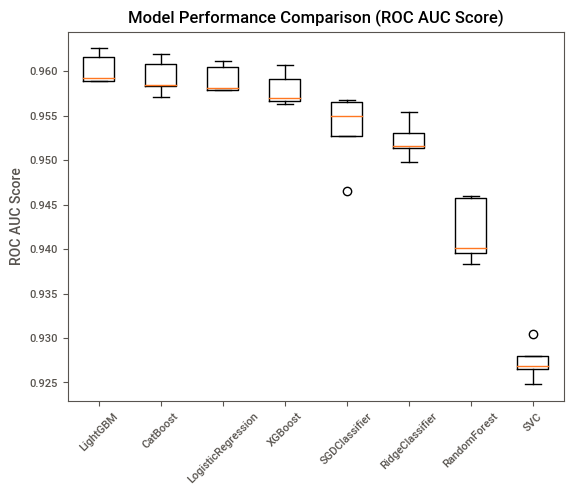

In [37]:
# Plotting model performances for ROC AUC
sorted_scores = {k: v for k, v in sorted(scores.items(), key=lambda item: -np.median(item[1]))}

plt.boxplot(sorted_scores.values(), labels=sorted_scores.keys())
plt.xticks(rotation=45)
plt.title('Model Performance Comparison (ROC AUC Score)')
plt.ylabel('ROC AUC Score')
plt.show()

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Models training 🤖</div>

In [38]:
# Define models
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

# Define objective functions for each model to be optimized using Optuna
# LightGBM
def objective_lgbm(trial):
    # Define hyperparameters for LightGBM
    lgbm_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # No None allowed here
        'num_leaves': trial.suggest_int('num_leaves', 31, 70),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False])  # Safe categorical
    }

    # Pipeline with preprocessor and LGBMClassifier
    pipeline_lgbm = Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('lgbm', LGBMClassifier(**lgbm_params, random_state=42, verbose=-1))
    ])
    
    # Avoiding numerical issues and handling potential warnings
    np.seterr(under='warn', over='warn')
    
    try:
        # Cross-validation with scoring set to 'roc_auc'
        scores = cross_val_score(pipeline_lgbm, X_train, y_train, cv=skf, scoring='roc_auc')
        return scores.mean()  # Return the mean score across folds
    except Exception as e:
        print(f"Trial failed with params: {lgbm_params}, error: {e}")
        return -np.inf  # Return negative infinity for failed trials

# XGBoost
def objective_xgb(trial):
    # Define hyperparameters for XGBoost
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'gamma': trial.suggest_float('gamma', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10)
    }

    # Pipeline with preprocessor and XGBoost Classifier
    pipeline_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('xgb', XGBClassifier(**xgb_params, random_state=42, verbosity=0))
    ])
    
    # Avoiding numerical issues
    np.seterr(under='warn', over='warn')
    
    try:
        # Cross-validation with 'roc_auc' scoring
        scores = cross_val_score(pipeline_xgb, X_train, y_train, cv=skf, scoring='roc_auc')
        return scores.mean()  # Return mean score
    except Exception as e:
        print(f"Trial failed with params: {xgb_params}, error: {e}")
        return -np.inf  # Return negative infinity for failed trials

def objective_rf(trial):
    # Define hyperparameters for Random Forest
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_categorical('max_depth', [10, 20, 30]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    # Pipeline with preprocessor and RandomForestClassifier
    pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('rf', RandomForestClassifier(**rf_params, random_state=42))
    ])
    
    # Avoiding numerical issues
    np.seterr(under='warn', over='warn')
    
    try:
        # Cross-validation with 'roc_auc' scoring
        scores = cross_val_score(pipeline_rf, X_train, y_train, cv=skf, scoring='roc_auc')
        return scores.mean()  # Return mean score
    except Exception as e:
        print(f"Trial failed with params: {rf_params}, error: {e}")
        return -np.inf  # Return negative infinity for failed trials

def objective_catboost(trial):
    catboost_params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 254),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10)
    }

    pipeline_catboost = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('catboost', CatBoostClassifier(**catboost_params, silent=True, random_state=42))
    ])

    scores = cross_val_score(pipeline_catboost, X_train, y_train, cv=skf, scoring='roc_auc')
    return scores.mean()

# Configure logging
logging.basicConfig(filename='optuna_log.txt', level=logging.INFO, format='%(asctime)s - %(message)s')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=N_TRIALS)

# Run Optuna optimization for CatBoost
study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=N_TRIALS)

# Retrieve best hyperparameters for each model
best_lgbm_params = study_lgbm.best_params
best_xgb_params = study_xgb.best_params
best_rf_params = study_rf.best_params
best_catboost_params = study_catboost.best_params

# Initialize models with best parameters
best_lgbm = LGBMClassifier(**best_lgbm_params, random_state=42, verbose=-1)
best_xgb = XGBClassifier(**best_xgb_params, random_state=42)
best_rf = RandomForestClassifier(**best_rf_params, random_state=42)
best_catboost = CatBoostClassifier(**best_catboost_params, random_state=42, silent=True)

# Expor the best parameters

best_params = {
    'LGBMClassifier': best_lgbm_params,
    'XGBClassifier': best_xgb_params,
    'RandomForestClassifier': best_rf_params,
    'CatBoostClassifier': best_catboost_params
}

filename = 'best_model_params.json'

with open(filename, 'w') as file:
    json.dump(best_params, file, indent=4)

# Voting classifier
voting_clf = VotingClassifier(estimators=[
    ('xgb', best_xgb),
    ('lgbm', best_lgbm),
    ('rf', best_rf),
    ('catboost', best_catboost)
], voting='soft')

# No need for additional preprocessor in the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', voting_clf)])

# Training and evaluating the ensemble model using AUC
cross_val_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
print(f"Ensemble Model AUC: {cross_val_scores.mean()} ± {cross_val_scores.std()}")

# Fit the model on the entire training data and evaluate on the test set
pipeline.fit(X_train, y_train)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Get predicted probabilities for positive class

# Calculating Metrics
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_pred_proba) 
print("AUC Score:", auc)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Ensemble Model AUC: 0.9609108198259226 ± 0.0016574516806930624


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


AUC Score: 0.9595379038660611


# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Prepare final submission</div>

In [39]:
# Step 1: Train the model on the full training dataset
pipeline.fit(X, y)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'mean_Working Professional or Student_Work Pressure',
       'std_Working Professional or Student_id',
       'std_Working Professional or Student_Financial Stress',
       'mean_Working Professional or Student_Ag...
                                                              reg_alpha=0.020241225457437773,
                                                              reg_lambda=0.03842166237256228,
                                                              subsample=0.6841927086138552,
                                                              verbose=-1)),
                                              ('rf',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_depth=30,
                                                                      max_features='auto',
                                                                      min_samples_leaf=4,
                                                                      min_samples_split=4,
                                                                      n_estimators=467,
                                                                      random_state=42)),
                                              ('catboost',
                                               <catboost.core.CatBoostClassifier object at 0x781a1038ef50>)],
                                  voting='soft'))])

In [40]:
# Step 2: Predictions on the test dataset
test_data_prepared = test_data_processed[selected_features]
y_test_pred = (pipeline.predict_proba(test_data_prepared)[:, 1] >= 0.5).astype(int)

# Step 3: Create the submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'loan_status': y_test_pred
})

# Ensure loan_status is integer type
submission['loan_status'] = submission['loan_status'].astype(int)

# Save the submission file
submission.to_csv('loan_prediction_submission.csv', index=False)